In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

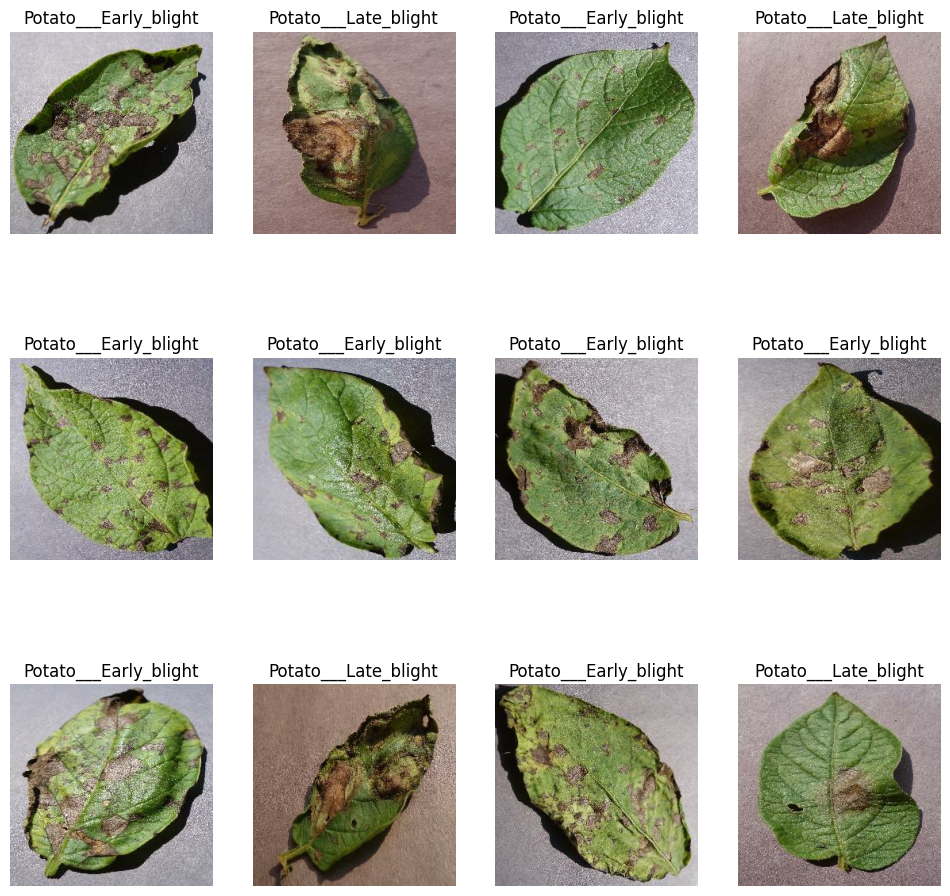

In [8]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:

train_size = 0.8
train_ds = dataset.take(int(train_size * len(dataset)))
test_ds = dataset.skip(int(train_size * len(dataset))).take(int((1 - train_size) * len(dataset)))
val_ds = test_ds.skip(6)

In [10]:
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffler_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffler_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


    return train_ds, val_ds,test_ds

In [11]:
train_ds, val_ds,test_ds = get_dataset_partition(dataset)

In [12]:
len(train_ds)

54

In [13]:
len(test_ds)

8

In [14]:
len(val_ds)

6

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [18]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1
)

Epoch 1/50


54/54 [==============================] - 27s 466ms/step - loss: 0.9061 - accuracy: 0.5104 - val_loss: 0.8829 - val_accuracy: 0.6615
Epoch 2/50
54/54 [==============================] - 22s 404ms/step - loss: 0.6768 - accuracy: 0.7014 - val_loss: 0.5277 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 22s 409ms/step - loss: 0.4082 - accuracy: 0.8281 - val_loss: 0.3071 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 24s 438ms/step - loss: 0.3114 - accuracy: 0.8779 - val_loss: 0.2143 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 23s 431ms/step - loss: 0.2043 - accuracy: 0.9213 - val_loss: 0.1286 - val_accuracy: 0.9479
Epoch 6/50
54/54 [==============================] - 20s 379ms/step - loss: 0.1752 - accuracy: 0.9300 - val_loss: 0.1330 - val_accuracy: 0.9583
Epoch 7/50
54/54 [==============================] - 22s 405ms/step - loss: 0.1386 - accuracy: 0.9450 - val_loss: 0.1298 - val_accuracy: 0.93

In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 96ms/step - loss: 0.0235 - accuracy: 0.9961


In [23]:
scores

[0.023462694138288498, 0.99609375]

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

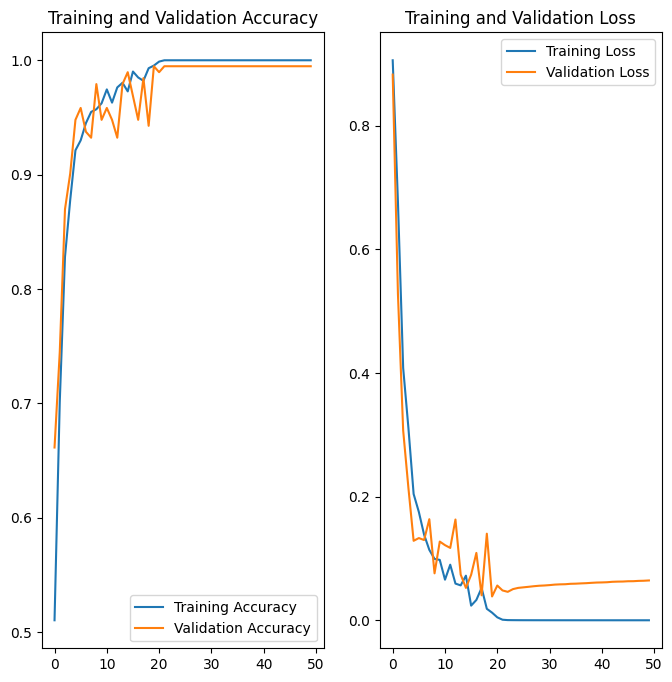

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict
first image's actual label: Potato___Late_blight
1/1 [==============================] - 0s 230ms/step
predicted label: Potato___Late_blight


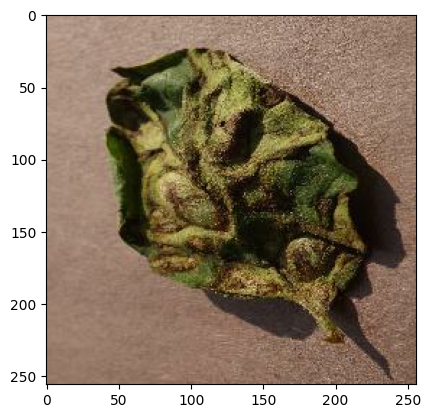

In [29]:
import numpy as np

for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("First image to predict")   
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  
    img_array = tf.expand_dims(img_array, 0) 
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


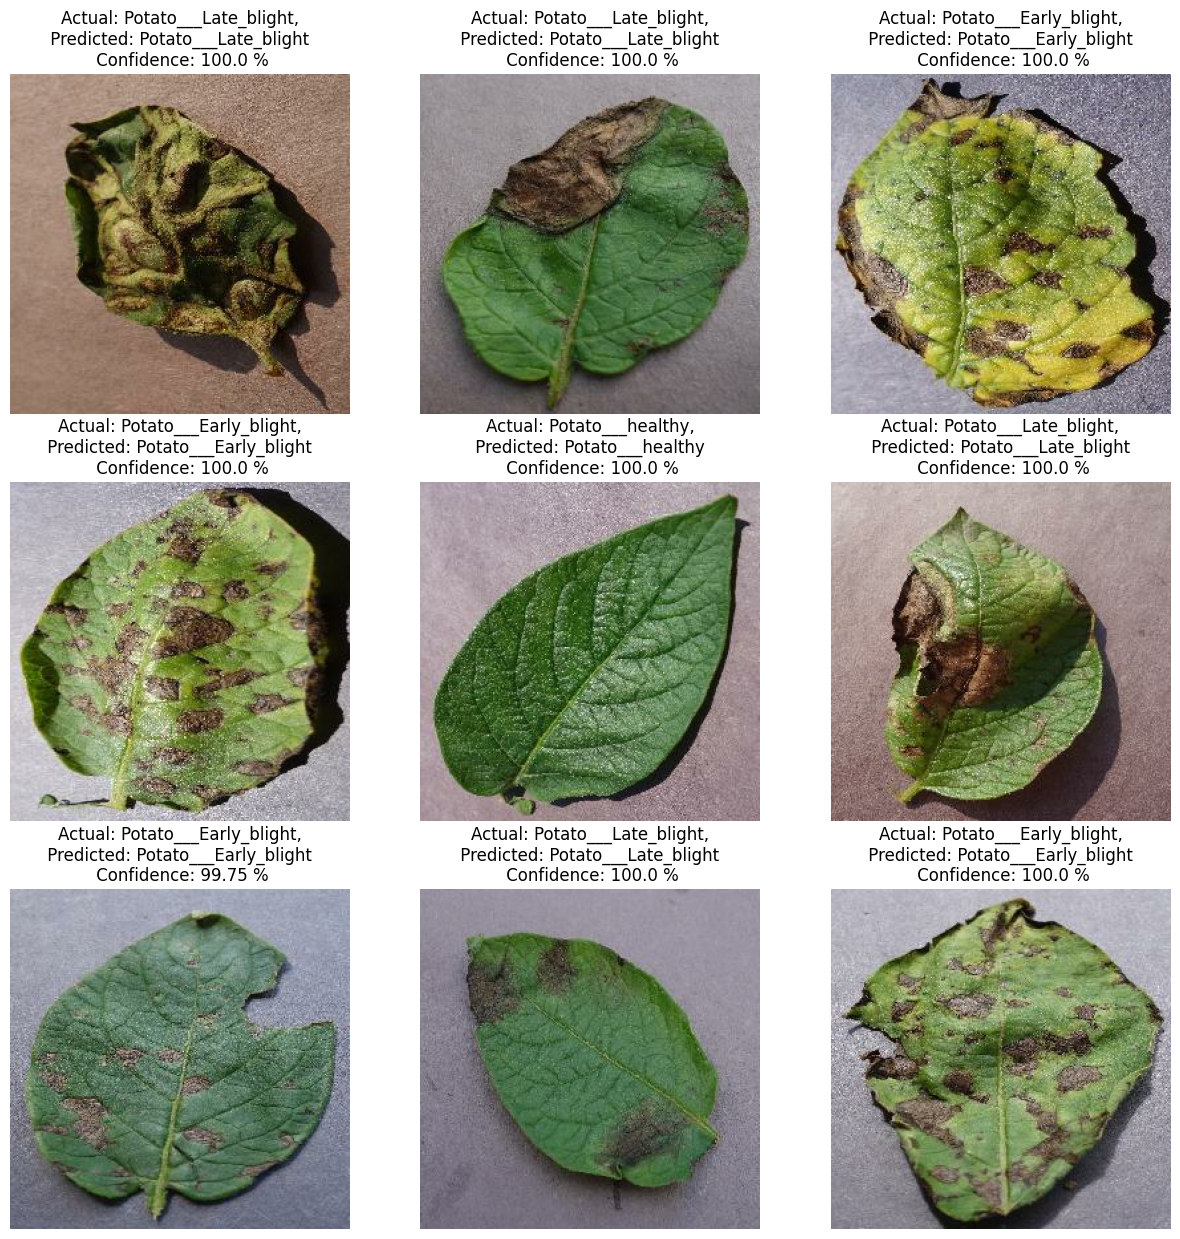

In [31]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class} \n Confidence: {confidence} %")

        plt.axis("off")

In [37]:

import os
model_version=max([int(i) for i in os.listdir("E:/Deep Learning/Potato Disease Classification/models") + [0]])+1
model.save(f"E:/Deep Learning/Potato Disease Classification/models/{model_version}")

INFO:tensorflow:Assets written to: E:/Deep Learning/Potato Disease Classification/models/1\assets


INFO:tensorflow:Assets written to: E:/Deep Learning/Potato Disease Classification/models/1\assets


In [41]:
model.save("E:/Deep Learning/Potato Disease Classification/models/potatoes.h5")

In [42]:
import tensorflow as tf
print(tf.__version__)


2.15.0
